### Welcome to Deep Learning with PyTorch Series of project 

- Deep Learning with PyTorch : Build a Neural Network 
- **Deep Learning with PyTorch : Convolutional Neural Network**
- Deep Learning with PyTorch : Neural Style Transfer
- Many more coming

# Deep Learning with PyTorch : Build a Convolutional Neural Network

In [49]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

## Task 1 : Load CIFAR-10 Dataset

![](cifar-10.png)

PyTorch transforms : https://pytorch.org/docs/stable/torchvision/transforms.html
- **For CIFAR-10 Dataset Channel mean is 0.4914, 0.4822, 0.4465**
- **Channel wise Standard Deviation is 0.2470, 0.2435, 0.2616**

In [50]:
from torchvision import transforms as T, datasets

* ToTensor() : converts numpy or PIL images to tensor. It also converts your image dimension to C x H x W because in pytorch for network input channel should be first 

* Normalize() : Takes channel wise mean-list and channel wise standard deviation-list

In [51]:
data_transforms = T.Compose([
    T.ToTensor(), # H x W x C -> C x H x W
    T.Normalize(mean = [0.4914, 0.4822, 0.4465],std = [0.2470, 0.2435, 0.2616])
])

#### Parameters in datasets submodule

* data_path
* train : True (to load train set) or False (to load test set)
* download : True (to download) or False
* transform : to apply transformation on data


CIFAR-10 consists of 60,000 tiny 32 x 32 x 3(RGB) images, labeled with an interger corresponding to 1 of 10 : classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [52]:
train_ds = datasets.CIFAR10('cifar10/', train = True, download = False, transform = data_transforms)
test_dataset = datasets.CIFAR10('cifar10/', train = False, download = False, transform = data_transforms)

In [53]:
print("Size of train set {}".format(len(train_ds)))
print("Size of test set {}".format(len(test_dataset)))

Size of train set 50000
Size of test set 10000


## Task 2 : Plot examples from dataset

In [54]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


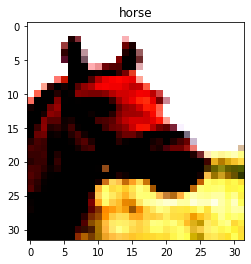

In [55]:
index = 99

image, label = test_dataset [index]

image = image.permute(1,2,0) #C(0) x H(1) x W(2)

#image = image * torch.Tensor([0.2470, 0.2435, 0.2616]) + torch.Tensor([0.4914, 0.4822, 0.4465])

plt.imshow(image)
plt.title(classes [label]);

## Task 3 : Load dataset into batches

In [56]:
from torch.utils.data import DataLoader, random_split

In [57]:
train_dataset, valid_dataset = random_split(train_ds, (45000,5000))

In [58]:
trainloader = DataLoader(train_dataset,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_dataset,batch_size = 64,shuffle = True)
testloader = DataLoader(test_dataset,batch_size = 64,shuffle = True)

In [59]:
print("Total batches created in Train loader : {}".format(len(trainloader)))
print("Total batches created in Valid loader : {}".format(len(validloader)))
print("Total batches created in Test loader : {}".format(len(testloader)))
print ("Size of train dataset {}".format(len(trainloader.dataset)))
print ("Size of valid dataset {}".format(len(validloader.dataset)))
print ("Size of test dataset {}".format(len(testloader.dataset)))

Total batches created in Train loader : 704
Total batches created in Valid loader : 79
Total batches created in Test loader : 157
Size of train dataset 45000
Size of valid dataset 5000
Size of test dataset 10000


In [60]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


## Task 4 : Create Convolutional Neural Network 

In [61]:
from torch import nn
import torch.nn.functional as F


k : kernel_size or filters 
<br>
p : padding 
<br>
s : stride 
<br>
W : Width 
<br>
H : Height 

\begin{equation*}
For Same padding = \frac{k - 1}{2} \\
\end{equation*}

\begin{equation*}
W[next] = \frac{W[previous] + 2p - k}{s} + 1 \\
\end{equation*}

\begin{equation*}
H[next] = \frac{H[previous] + 2p - k}{s} + 1 \\
\end{equation*}

In [62]:
'''
3 x 32 x 32 (input)

       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1
       V activation = relu 
       
16 x 32 x 32

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
16 x 15 x 15

       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2
       V activation = relu
       
32 x 15 x 15 

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
32 x 8 x 8

       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3
       V activation = relu 
       
64 x 8 x 8

       | k = (2,2), s = 2 , operation = MaxPooling #maxpool
       V

64 x 4 x  4
    
       |  operation = Flatten
       V
500

       |  linear,activation = relu #linear1
       V

128
       |  linear,activation = relu #linear2
       V

10  linear, activation = log_softmax #linear3
'''

'\n3 x 32 x 32 (input)\n\n       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1\n       V activation = relu \n       \n16 x 32 x 32\n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n16 x 15 x 15\n\n       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2\n       V activation = relu\n       \n32 x 15 x 15 \n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n32 x 8 x 8\n\n       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3\n       V activation = relu \n       \n64 x 8 x 8\n\n       | k = (2,2), s = 2 , operation = MaxPooling #maxpool\n       V\n\n64 x 4 x  4\n    \n       |  operation = Flatten\n       V\n500\n\n       |  linear,activation = relu #linear1\n       V\n\n128\n       |  linear,activation = relu #linear2\n       V\n\n10  linear, activation = log_softmax #linear3\n'

In [63]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel,self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels = 3,out_channels = 16, kernel_size = (3,3), padding = 1,stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 16,out_channels = 32, kernel_size = (3,3), padding = 1,stride = 1)
        self.conv_3 = nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = (3,3), padding = 1,stride = 1)
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2),stride = 2)
        
        self.linear_1 = nn.Linear(in_features = 1024, out_features = 500)
        self.linear_2 = nn.Linear(in_features = 500, out_features = 128)
        self.linear_3 = nn.Linear(in_features = 128, out_features = 10)
        
        
    def forward(self,images):
        
        #images : 3 x 32 x 32
        
        a1 = self.maxpool(F.relu(self.conv_1(images)))
        
        a2 = self.maxpool(F.relu(self.conv_2(a1)))
        
        a3 = self.maxpool(F.relu(self.conv_3(a2)))
        
        a3 = a3.view(a3.shape[0],-1) #(bs,64,4,4) -> (bs,64*4*4) -> (bs,1024)
        
        a4 = F.relu(self.linear_1(a3))
        
        a5 = F.relu(self.linear_2(a4))
        
        a6 = F.log_softmax(self.linear_3(a5),dim = 1)
        
        return a6

In [64]:
model = MyModel()
model

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [65]:
from torchsummary import summary

In [66]:
summary(model,input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

## Task 5 : Training loop

In [69]:
from torch import optim
from utils import multiclass_accuracy
from tqdm import tqdm

criterion = nn.NLLLoss() #(logps,true_labels)
optimizer = optim.Adam(model.parameters(),lr = 0.003)
epochs = 10

In [71]:
for i in range(epochs):

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    model.train()
    
    for images,labels in tqdm(trainloader):
    
       logps = model (images) #outputs ps
       
       loss = criterion(logps,labels)
       
       optimizer.zero_grad()
       loss.backward() #dw,db
       optimizer.step() # w = w - lr*dw
       
       train_loss += loss.item()
       ps = torch.exp(logps) #log_softmax -> softmax
       train_acc += multiclass_accuracy(ps,labels)
       
    model.eval() #droput,batch norm
    
    for images,labels in tqdm(validloader):
    
        logps = model(images)
        loss = criterion(logps,labels)
        
        valid_loss += loss.item()
        ps = torch.exp(logps)
        valid_acc += multiclass_accuracy(ps,labels)
        
    avg_train_loss = train_loss/len(trainloader)  
    avg_valid_loss = valid_loss/len(validloader) 
    avg_train_acc = train_acc/len(trainloader) 
    avg_valid_acc = valid_acc/len(validloader) 
    
    print("Epoch : {} Train Loss : {:.4f} Train Acc: {:.4f}".format(i,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.4f} Valid Acc: {:.4f}".format(i,avg_valid_loss,avg_valid_acc))

  0%|          | 2/704 [00:00<01:00, 11.52it/s]

Epoch : 0 Train Loss : 1.4293 Train Acc: 0.4749
Epoch : 0 Valid Loss : 1.2020 Valid Acc: 0.5661


  0%|          | 2/704 [00:00<00:56, 12.51it/s]

Epoch : 1 Train Loss : 1.0380 Train Acc: 0.6283
Epoch : 1 Valid Loss : 0.9897 Valid Acc: 0.6499


  0%|          | 1/704 [00:00<01:44,  6.72it/s]

Epoch : 2 Train Loss : 0.8752 Train Acc: 0.6912
Epoch : 2 Valid Loss : 0.8793 Valid Acc: 0.6903


  0%|          | 2/704 [00:00<01:02, 11.25it/s]

Epoch : 3 Train Loss : 0.7690 Train Acc: 0.7283
Epoch : 3 Valid Loss : 0.8792 Valid Acc: 0.6901


  0%|          | 1/704 [00:00<01:17,  9.06it/s]

Epoch : 4 Train Loss : 0.6866 Train Acc: 0.7592
Epoch : 4 Valid Loss : 0.9840 Valid Acc: 0.6719


  0%|          | 2/704 [00:00<00:57, 12.21it/s]

Epoch : 5 Train Loss : 0.6160 Train Acc: 0.7815
Epoch : 5 Valid Loss : 1.0186 Valid Acc: 0.6630


  0%|          | 2/704 [00:00<00:46, 15.01it/s]

Epoch : 6 Train Loss : 0.5595 Train Acc: 0.8040
Epoch : 6 Valid Loss : 0.9403 Valid Acc: 0.7033


  0%|          | 1/704 [00:00<01:27,  8.07it/s]

Epoch : 7 Train Loss : 0.5070 Train Acc: 0.8211
Epoch : 7 Valid Loss : 0.9785 Valid Acc: 0.7021


  0%|          | 2/704 [00:00<01:02, 11.20it/s]

Epoch : 8 Train Loss : 0.4744 Train Acc: 0.8322
Epoch : 8 Valid Loss : 0.9918 Valid Acc: 0.7061


100%|██████████| 79/79 [00:03<00:00, 22.24it/s]

Epoch : 9 Train Loss : 0.4182 Train Acc: 0.8533
Epoch : 9 Valid Loss : 1.1429 Valid Acc: 0.6828


## Task 6 : Evaluate model 

In [72]:
from utils import view_classify

In [73]:
test_loss = 0.0
test_acc = 0.0

model.eval() # dropout,batch norm

for images,labels in tqdm(testloader):
    
    logps = model (images)
    loss = criterion(logps,labels)
    test_loss += loss.item()
    ps = torch.exp(logps)
    test_acc += multiclass_accuracy(ps,labels)
    
    
avg_test_loss = test_loss/len(testloader)
avg_test_acc = test_acc/len(testloader)
print("Test Loss: {:.4f} Test Acc: {:.4f}".format(avg_test_loss,avg_test_acc))

100%|██████████| 157/157 [00:07<00:00, 21.52it/s]

Test Loss: 1.1232 Test Acc: 0.6885


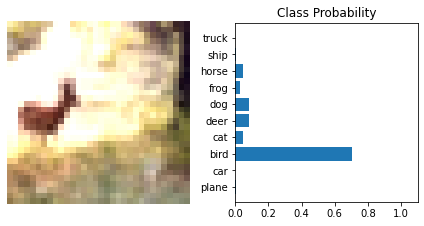

In [76]:
dataiter = iter(testloader)

images,labels = dataiter.next()

index = 2
logps = model(images[index].unsqueeze(0)) #(3,32,32) -> (1,3,32,32)
ps = torch.exp(logps)

view_classify(images[index],ps)